# Model 1: Predicting EVD(+) vs EVD(-)
Replicate the model for predicting Ebola infection (EVD+ vs EVD-) from Annie's 2017 paper.
It will serve along with other models, to evaluate the developed methods for model personalisation through data selection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection as sk_ms, linear_model as sk_lm

In [2]:
# Load the pre-processed dataset:
df = pd.read_csv('../data/private/1_TreatMissing_EbolaDatabase.csv')
df.head(0) # DO NOT PUSH A COMMIT WHERE ANY LINE IS VISIBLE

,Unnamed: 0,study_id,evd,evd_ct,malaria,death,sex,age,quarantine,days_admitted,...,hematuria_after,gyne_hemorrhage_after,num_hemorrhage_sites_after,dehydration_after,hepatomegaly_after,jaundice_after,edema_after,splenomegaly_after,referral(4-9),quarantine_missing


## Build the feature matrix $\mathbf{X}$ and the target vector $\mathbf{y}$ 

In [3]:
np.array([c for c in df.columns if not 'after' in c])

array(['Unnamed: 0', 'study_id', 'evd', 'evd_ct', 'malaria', 'death',
       'sex', 'age', 'quarantine', 'days_admitted', 'referral_time',
       'date_admis', 'temp_triage', 'pyrexia_triage', 'anuria_triage',
       'dyspnea_triage', 'disorientation_triage', 'headache_triage',
       'hiccups_triage', 'myalgia_triage', 'rash_triage',
       'dysphagia_triage', 'asthenia_triage', 'abdomnial_triage',
       'anorexia_triage', 'diarrhea_triage', 'diarrhea_score_triage',
       'vomiting_triage', 'hemorrhage_triage', 'orl_hemorrhage_triage',
       'conjonctivitis_triage', 'hemoptysis_triage',
       'hematochezia_triage', 'hematuria_triage',
       'gynec_hemorrhage_triage', 'num_hemorrhages_triage',
       'mult_hemorrhage_triage', 'dehydration_triage',
       'hepatomegaly_triage', 'jaundice_triage', 'edema_triage',
       'splenomegaly_triage', 'referral(4-9)', 'quarantine_missing'],
      dtype='<U23')

Of course, the prediction model is not useful if it relies on features collected upon release of the patients (by that time, the outcome is known).
We therefore focus our efforts on the features collected during patient triage.

Diarrhea is used in the model proposed in Annie's paper, and it seems to be a binary feature.
Here, however, we have two features at our disposal:
- `diarrhea_triage` is simply binary.
- `diarrhea_score_triage` is an ordered variable, going from 0 to 3 in integer steps depending on the number of diarrhea episodes experienced by the patient.

We plot `evd` against `diarrhea_score_triage` to identify whether a linear correlation exists:

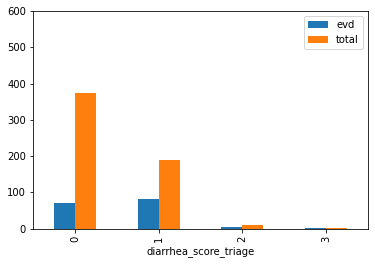

In [4]:
df_diarrhea = df.loc[:, ['evd', 'diarrhea_score_triage']]
df_diarrhea['total'] = 1
df_diarrhea.groupby('diarrhea_score_triage').sum().plot(ylim=(0,600), kind='bar')

On second thought, there really are not enough samples for `diarrhea_score_triage > 1` to conduct a meaningful analysis (10 with a score of 2, and 2 with a score of 3). Therefore, we use the binary variable `diarrhea_triage`.

In [5]:
targets = ['evd']
predictors = ['quarantine', 'quarantine_missing', 'conjonctivitis_triage', 'diarrhea_triage', 'referral(4-9)', 'pyrexia_triage', 'dysphagia_triage', 'hemorrhage_triage', 'myalgia_triage' ]
assert set(predictors).issubset(df.columns)
assert set(targets).issubset(df.columns)

In [6]:
X = df.loc[:, predictors].copy()
print(len(X))
X.head(0)

575


,quarantine,quarantine_missing,conjonctivitis_triage,diarrhea_triage,referral(4-9),pyrexia_triage,dysphagia_triage,hemorrhage_triage,myalgia_triage


In [7]:
y = df.loc[:, targets].copy()
print(len(y))
y.head(0)

575


,evd


In [8]:
X_train, X_test, y_train, y_test = sk_ms.train_test_split(X,y, shuffle=True)
X_test.shape

(144, 9)

## Save the feature matrix $\mathbf{X}$ and the target vector $\mathbf{y}$ 

In [9]:
import os
save_dir = '../data/private/predict_EVD'
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
X.to_csv(os.path.join(save_dir, 'X.csv'), index=False)
y.to_csv(os.path.join(save_dir, 'y.csv'), index=False)

## Train a logistic regression model

In [69]:
model = sk_lm.LogisticRegressionCV(Cs=np.logspace(-3,1,num=60), cv=4)

In [70]:
model.fit(X_train, y_train)
print("Inverse of regularisation coefficient:", model.C_[0])
avg_scores = model.scores_[1].mean(axis=0)
print("Corresponding validation score (averaged across folds):", avg_scores.max()*100, "%")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=array([1.00000000e-03, 1.16895182e-03, 1.36644835e-03, 1.59731228e-03,
       1.86718109e-03, 2.18264473e-03, 2.55140652e-03, 2.98247129e-03,
       3.48636523e-03, 4.07539297e-03, 4.76393801e-03, 5.56881399e-03,
       6.50967523e-03, 7.60949669e-03, 8.89513497e-03, 1.03979842e-02,
       1.21547425e-02, 1.42083083e-02, 1.66088278e-02, 1.94149195e-02,
       2.26951054e-02, 2.65...
       1.79571449e+00, 2.09910372e+00, 2.45375111e+00, 2.86831681e+00,
       3.35292415e+00, 3.91940677e+00, 4.58159767e+00, 5.35566692e+00,
       6.26051657e+00, 7.31824222e+00, 8.55467254e+00, 1.00000000e+01]),
                     class_weight=None, cv=4, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=100,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

Text(0, 0.5, 'Accuracy [%]')

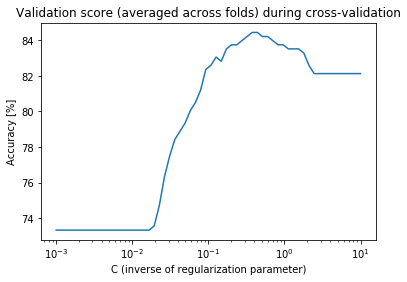

In [71]:
plt.semilogx(model.Cs_, avg_scores*100)
plt.title('Validation score (averaged across folds) during cross-validation')
plt.xlabel('C (inverse of regularization parameter)')
plt.ylabel('Accuracy [%]')

In [75]:

avg_scores = model.scores_[1].mean(axis=0)
print("Corresponding validation score (averaged across folds):", avg_scores.max())

Corresponding validation score (averaged across folds): 0.844496365524403


## Evaluate the model

We begin by evaluating its score (accuracy) on the test set:

In [76]:
model.score(X_test, y_test)

0.7916666666666666

The model generalizes medium well: Its test error (1-accuracy) is 34% greater than its validation error. In particular, the accuracy of 79% on the test set is lower than the accuracy of 89% obtained in Annie's paper.

Finally, we display the intercept and the coefficients and compare them with the model described in Annie's paper:

In [79]:
print('Intercept:', model.intercept_)
print('Coefficients:\n', dict(zip(predictors, model.coef_.flat)))

Intercept: [-2.82815156]
Coefficients:
 {'quarantine': 1.819751771499741, 'quarantine_missing': 0.353819697770931, 'conjonctivitis_triage': 1.3966816480481956, 'diarrhea_triage': 1.0488543066967129, 'referral(4-9)': 1.0816016292060706, 'pyrexia_triage': 0.3769283857926169, 'dysphagia_triage': 0.5626054205326325, 'hemorrhage_triage': 0.3764649262842281, 'myalgia_triage': -0.36070330201615547}


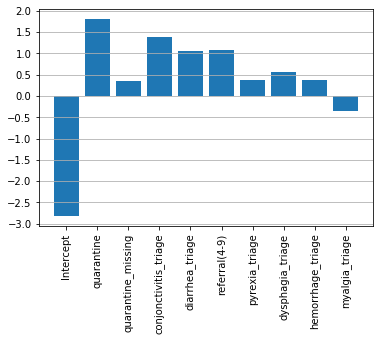

In [86]:
plt.bar(['Intercept']+predictors, list(model.intercept_.flat) + list(model.coef_.flat))
plt.xticks(rotation=90)
plt.yticks(ticks=np.arange(-3, 2.5, 0.5))
plt.grid(axis='y')
plt.show()

The coefficients are similar (not in absolute value, of course) to those found in Annie's paper:
- sick contact is the strongest (positive) predictor
- conjunctivitis is the next strongest (its coefficient is 2/3 of the quarantine coef in the paper)
- diarrhea and referral(4-9) are next (their coefficient is 1/2 of the quarantine coef in the paper)
- Then come dysphagia and hemorrhage (their coefficient is 1/3 of the quarantine coef in the paper)
- Pyrexia is the weakest positive predictor (its coefficient is 1/6 of the quarantine coef in the paper)
- Finally, myalgia is a mild negative predictor (its coefficient is -1/3 of the quarantine coef in the paper)

Hemorrhage and myalgia are found somewhat weaker here, but the similarity is good overall.

In [85]:
print("mean of the available values for `quarantine`:", df['quarantine'].sum() / (len(df) - df['quarantine_missing'].sum()))
print("Coef for quarantine_missing VS coef for quarantine:", model.coef_.flat[1] / model.coef_.flat[0])

mean of the available values for `quarantine`: 0.24682395644283123
Coef for quarantine_missing VS coef for quarantine: 0.194432945917306
